In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
## Reading data

data = pd.read_csv("/content/jena_climate_2009_2016.csv")
data.head()
print(data.shape)

(420551, 15)


In [27]:
## Changing date format

data.index = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
data.index.name = 'Date'
data.drop('Date Time', axis=1, inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


array([<Axes: xlabel='Date'>], dtype=object)

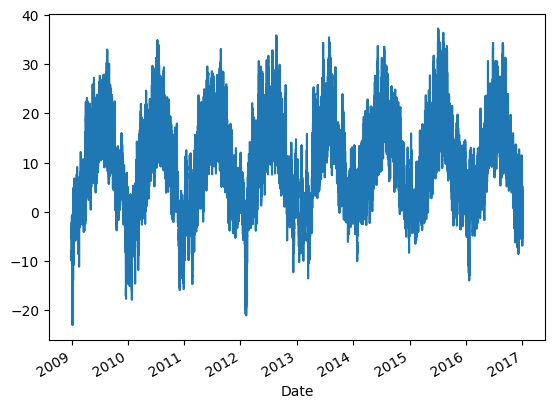

In [28]:
## Temperature data

temp = data['T (degC)']
temp.plot(subplots=True)

In [29]:
## Temperature converting to numpy array with window size 5 and Label to y

def data_Xy(data):
    data_as_np = data.to_numpy()
    X = []
    y = []
    window_size = 5

    for i in range(len(data_as_np)-window_size):
        row = [[a] for a in data_as_np[i:i+5]]
        X.append(row)
        y.append(data_as_np[i+5])
    return np.array(X), np.array(y)

In [30]:
## Converting into numpy array FEATURES(X) and LABEL(y)

X, y = data_Xy(temp)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (420546, 5, 1)
y shape: (420546,)


In [31]:
from sklearn.model_selection import train_test_split

# Splitting data

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (336436, 5, 1)
y_train shape: (336436,)
X_val shape: (42055, 5, 1)
y_val shape: (42055,)
X_test shape: (42055, 5, 1)
y_test shape: (42055,)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

## Building model

model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [33]:
## Finding best

cp = ModelCheckpoint('best_model', save_best_only=True)


## Loss function

model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=[RootMeanSquaredError()])

In [34]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp])

Epoch 1/5
10513/10514 [============================>.] - ETA: 0s - loss: 4.3930 - root_mean_squared_error: 2.0959

10514/10514 [==============================] - 88s 8ms/step - loss: 4.3927 - root_mean_squared_error: 2.0959 - val_loss: 0.0541 - val_root_mean_squared_error: 0.2326
Epoch 2/5
10513/10514 [============================>.] - ETA: 0s - loss: 0.0470 - root_mean_squared_error: 0.2168

10514/10514 [==============================] - 79s 7ms/step - loss: 0.0470 - root_mean_squared_error: 0.2168 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2142
Epoch 3/5
10513/10514 [============================>.] - ETA: 0s - loss: 0.0448 - root_mean_squared_error: 0.2116

10514/10514 [==============================] - 77s 7ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2084
Epoch 4/5
10514/10514 [==============================] - 74s 7ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2086
Epoch 5/5
10509/10514 [============================>.] - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.2098

10514/10514 [==============================] - 78s 7ms/step - loss: 0.0440 - root_mean_squared_error: 0.2099 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2070


In [35]:
## Predictions

temp_predictions = model.predict(X_test).flatten()
temp_predictions

1315/1315 [==============================] - 4s 3ms/step


array([23.31089  , 25.095638 ,  4.9805675, ..., 26.583649 , -6.767265 ,
        5.037023 ], dtype=float32)

In [36]:
## Converting into a dataframe

results = pd.DataFrame(data={'Predictions': temp_predictions, 'Actuals': y_test.flatten()})
results

,Predictions,Actuals
0,23.310890,23.13
1,25.095638,25.28
2,4.980567,5.00
3,5.929030,5.93
4,12.513262,12.46
...,...,...
42050,10.523058,9.87
42051,2.124986,2.00
42052,26.583649,26.89
42053,-6.767265,-7.38


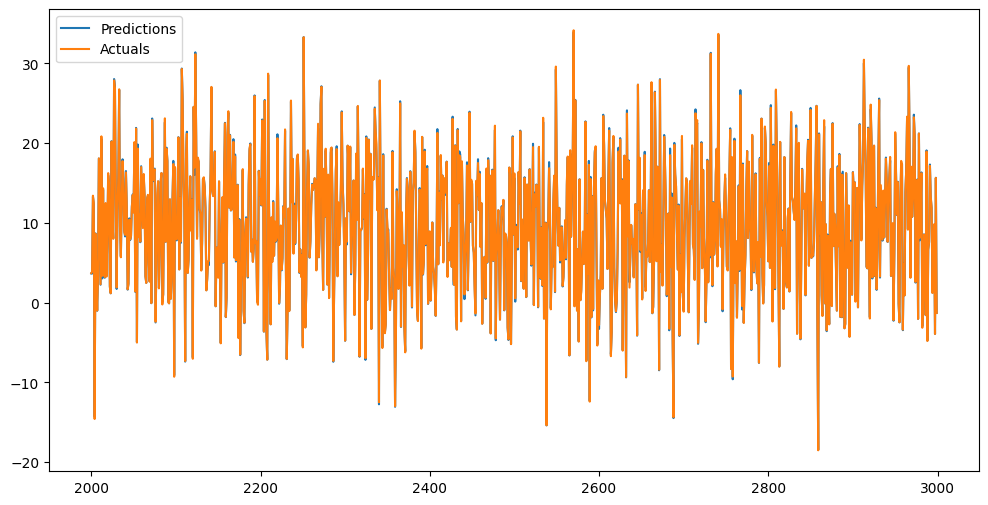

In [37]:
## Plotting predictions with actuals

plt.figure(figsize=(12, 6))
plt.plot(results['Predictions'][2000:3000], label='Predictions')
plt.plot(results['Actuals'][2000:3000], label='Actuals')
plt.legend()
plt.show()